# Avaliação - Parte Prática

# Pedro Buczinski Lages de Carvalho - 12555266

$MSE$ direção: $0,09$       
$MSE$ velocidade: $120,31$ \\
$R^2$ direção: $0,99$  
$R^2$ velocidade: $0,99$


## 1. Carregamento e Pré-processamento

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [20]:
from google.colab import drive
drive.mount('/content/drive')

try:
  X_train = pd.read_csv('X_train.csv').to_numpy()
  y_train = pd.read_csv('y_train.csv').to_numpy()
  X_test = pd.read_csv('X_test.csv').to_numpy()
  y_test = pd.read_csv('y_test.csv').to_numpy()
except:
  X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSI3471/Parte 1/EP Prova/X_train.csv").to_numpy()
  y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSI3471/Parte 1/EP Prova/y_train.csv").to_numpy()
  X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSI3471/Parte 1/EP Prova/X_test.csv").to_numpy()
  y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSI3471/Parte 1/EP Prova/y_test.csv").to_numpy()


# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# PCA (95% da variância explicada)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled) #o X_test mantém todos os exemplos originais, apenas representados num novo espaço dimensional consistente com o modelo treinado.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
X_train_pca.shape

(19628, 9)

In [22]:
y_train.shape

(19628, 2)

In [23]:
X_test_pca.shape

(4907, 9)

In [24]:
y_test.shape

(4907, 2)

## 2. Definição do Modelo

In [25]:
# Ajuste de hiperparâmetros

# passo de adaptação da rede MLP
eta = 0.005

# Tamanho do mini-batch
Nb = 200

# Número de épocas
Ne = 2000

In [26]:
class Model(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.model(x)

def weights_init_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu', a=0.01)
        nn.init.zeros_(m.bias)


## 3. Treinamento com Validação

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

train_set = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size=Nb, shuffle=True)

model = Model(input_size = X_train_pca.shape[1]).to(device)
model.apply(weights_init_he)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

train_losses, test_losses = [], []
best_test_loss = float('inf')
best_model_state = None

for epoch in range(Ne):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_function(pred, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_tensor.to(device))
        test_loss = loss_function(test_pred, y_test_tensor.to(device)).item()

    train_losses.append(loss.item())
    test_losses.append(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_state = model.state_dict()


    if epoch % 100 == 0:
        print(f"Época {epoch} | Loss de treino: {loss.item():.4f} |  Loss de validação: {test_loss:.4f}")

Época 0 | Loss de treino: 0.3824 |  Loss de validação: 0.2611
Época 100 | Loss de treino: 0.0032 |  Loss de validação: 0.0142
Época 200 | Loss de treino: 0.0033 |  Loss de validação: 0.0099
Época 300 | Loss de treino: 0.0030 |  Loss de validação: 0.0111
Época 400 | Loss de treino: 0.0030 |  Loss de validação: 0.0096
Época 500 | Loss de treino: 0.0015 |  Loss de validação: 0.0079
Época 600 | Loss de treino: 0.0018 |  Loss de validação: 0.0084
Época 700 | Loss de treino: 0.0083 |  Loss de validação: 0.0100
Época 800 | Loss de treino: 0.0011 |  Loss de validação: 0.0079
Época 900 | Loss de treino: 0.0013 |  Loss de validação: 0.0088
Época 1000 | Loss de treino: 0.0031 |  Loss de validação: 0.0100
Época 1100 | Loss de treino: 0.0031 |  Loss de validação: 0.0078
Época 1200 | Loss de treino: 0.0019 |  Loss de validação: 0.0078
Época 1300 | Loss de treino: 0.0042 |  Loss de validação: 0.0092
Época 1400 | Loss de treino: 0.0051 |  Loss de validação: 0.0091
Época 1500 | Loss de treino: 0.0021 |

## 4. Avaliação Final

In [28]:
torch.save(best_model_state,  "./model01.pt")
model.load_state_dict(torch.load( "./model01.pt"))
model.eval()

with torch.no_grad():
    y_pred_scaled = model(X_test_tensor.to(device)).cpu().numpy()

y_pred = scaler.inverse_transform(y_pred_scaled)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

print(f"MSE direção: {mse[0]:.4f}, MSE velocidade: {mse[1]:.4f}")
print(f"R² direção: {r2[0]:.4f}, R² velocidade: {r2[1]:.4f}")

MSE direção: 0.0949, MSE velocidade: 120.3143
R² direção: 0.9959, R² velocidade: 0.9871


## 5. Curvas de Aprendizado

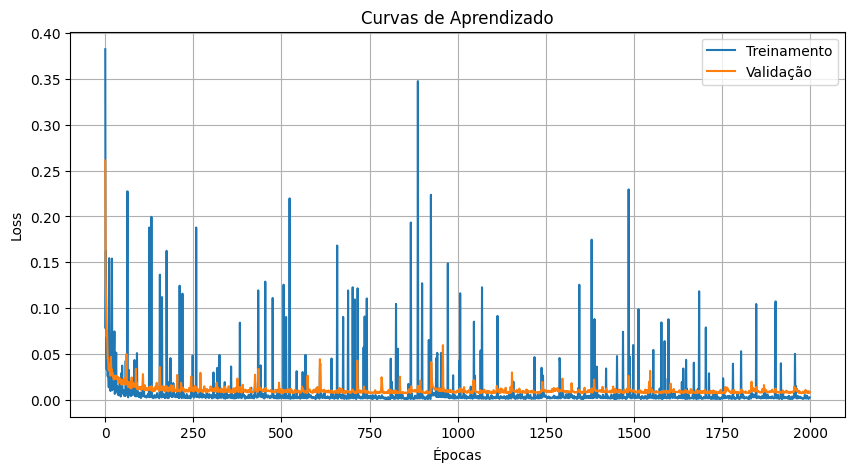

In [29]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Treinamento")
plt.plot(test_losses, label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Curvas de Aprendizado")
plt.legend()
plt.grid(True)
plt.show()